In [1]:
# Seed value
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
print(tf.__version__) 

tf.random.set_seed(seed_value)     


2.2.0


In [2]:
import os
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

dataset = pd.read_csv('st7_train_95_13.csv', header=0, index_col=0)

print('Length of raw data is: ', dataset.shape)
data_org = dataset.iloc[:, :].values
size_train = int(len(data_org) * 0.8)                

data_train = data_org[0 : size_train]
data_valid = data_org[size_train : len(data_org)]
scaler = MinMaxScaler()

train_data = scaler.fit_transform(data_train)
valid_data = scaler.transform(data_valid)


Length of raw data is:  (6575, 7)


In [3]:
from tensorflow import keras
from keras import optimizers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import LSTM, LSTMCell, GRU, GRUCell, Bidirectional

input_dim = data_org.shape[1]                 
output_dim = 1
seq_length = 8                              

save_dir = 'st7_checkpoints/'
model_name = 'stlstm_1d8.hdf5'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, model_name)

n = 1                                         
def split_data(x_data):
    dataX = []
    dataY = []
    y_data = x_data[:, [-1]]
    for i in range(seq_length, len(y_data) - (n-1)):
        _x = x_data[i - seq_length : i]
        _y = y_data[i + (n-1)] 
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = split_data(train_data)
validX, validY = split_data(valid_data)
print('Length of train data: ', len(trainX))

print('Train data shape: trainX; trainY: ', np.shape(trainX), np.shape(trainY))
print('Valid data shape: validX; validY: ', np.shape(validX), np.shape(validY))

Using TensorFlow backend.


Length of train data:  5252
Train data shape: trainX; trainY:  (5252, 8, 7) (5252, 1)
Valid data shape: validX; validY:  (1307, 8, 7) (1307, 1)


In [4]:
num_units = 8                                

model = keras.Sequential()
inputs = (trainX.shape[1], trainX.shape[2])

model.add(LSTM(units=num_units, return_sequences=True, input_shape=inputs))
model.add(Dropout(rate=0.2))
model.add(LSTM(units=num_units, return_sequences=True))            
model.add(Dropout(rate=0.2))
model.add(LSTM(units=num_units))            
model.add(Dropout(rate=0.2))

model.add(Dense(output_dim))

model.compile(loss='mean_squared_error',
              optimizer= keras.optimizers.Adam(0.001),   
              metrics=['accuracy']) 

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 8)              512       
_________________________________________________________________
dropout (Dropout)            (None, 8, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 8)              544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 9

In [5]:
min_required = 1e-5       
num_improvement = 2000      
num_period = 10            
num_epochs = 50000

es = EarlyStopping(monitor='val_loss', 
                   min_delta= min_required, 
                   patience=num_improvement, 
                   verbose=1, 
                   mode='auto')
mc = ModelCheckpoint(filepath=save_path, 
                     monitor='val_loss', 
                     verbose=1, save_best_only=True,  
                     mode='auto', 
                     period = num_period)
history = model.fit(trainX, trainY,
                    epochs=num_epochs,
                    batch_size = 32,
                    validation_data=(validX, validY),     
                    callbacks=[es, mc],
                    verbose = 2)
            
history_dict = history.history
print(history_dict.keys())


Epoch 1/50000
165/165 - 2s - loss: 0.0088 - accuracy: 3.8081e-04 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 2/50000
165/165 - 1s - loss: 0.0062 - accuracy: 3.8081e-04 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 3/50000
165/165 - 1s - loss: 0.0055 - accuracy: 3.8081e-04 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 4/50000
165/165 - 1s - loss: 0.0050 - accuracy: 3.8081e-04 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 5/50000
165/165 - 1s - loss: 0.0045 - accuracy: 3.8081e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 6/50000
165/165 - 1s - loss: 0.0040 - accuracy: 3.8081e-04 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 7/50000
165/165 - 1s - loss: 0.0036 - accuracy: 3.8081e-04 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 8/50000
165/165 - 1s - loss: 0.0033 - accuracy: 3.8081e-04 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 9/50000
165/165 - 1s - loss: 0.0028 - accuracy: 3.8081e-04 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
E

Epoch 66/50000
165/165 - 1s - loss: 0.0013 - accuracy: 3.8081e-04 - val_loss: 3.6578e-04 - val_accuracy: 0.0000e+00
Epoch 67/50000
165/165 - 1s - loss: 0.0013 - accuracy: 3.8081e-04 - val_loss: 2.9472e-04 - val_accuracy: 0.0000e+00
Epoch 68/50000
165/165 - 1s - loss: 0.0012 - accuracy: 3.8081e-04 - val_loss: 3.4936e-04 - val_accuracy: 0.0000e+00
Epoch 69/50000
165/165 - 1s - loss: 0.0012 - accuracy: 3.8081e-04 - val_loss: 4.5696e-04 - val_accuracy: 0.0000e+00
Epoch 70/50000

Epoch 00070: val_loss did not improve from 0.00033
165/165 - 1s - loss: 0.0013 - accuracy: 3.8081e-04 - val_loss: 4.2219e-04 - val_accuracy: 0.0000e+00
Epoch 71/50000
165/165 - 1s - loss: 0.0012 - accuracy: 3.8081e-04 - val_loss: 3.5857e-04 - val_accuracy: 0.0000e+00
Epoch 72/50000
165/165 - 1s - loss: 0.0013 - accuracy: 3.8081e-04 - val_loss: 3.3499e-04 - val_accuracy: 0.0000e+00
Epoch 73/50000
165/165 - 1s - loss: 0.0014 - accuracy: 3.8081e-04 - val_loss: 2.5955e-04 - val_accuracy: 0.0000e+00
Epoch 74/50000
165/1

Epoch 132/50000
165/165 - 1s - loss: 0.0012 - accuracy: 3.8081e-04 - val_loss: 3.4384e-04 - val_accuracy: 0.0000e+00
Epoch 133/50000
165/165 - 1s - loss: 0.0013 - accuracy: 3.8081e-04 - val_loss: 2.8012e-04 - val_accuracy: 0.0000e+00
Epoch 134/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 4.1330e-04 - val_accuracy: 0.0000e+00
Epoch 135/50000
165/165 - 1s - loss: 0.0012 - accuracy: 3.8081e-04 - val_loss: 3.5541e-04 - val_accuracy: 0.0000e+00
Epoch 136/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.0854e-04 - val_accuracy: 0.0000e+00
Epoch 137/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.5700e-04 - val_accuracy: 0.0000e+00
Epoch 138/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 3.9453e-04 - val_accuracy: 0.0000e+00
Epoch 139/50000
165/165 - 1s - loss: 0.0012 - accuracy: 3.8081e-04 - val_loss: 2.2825e-04 - val_accuracy: 0.0000e+00
Epoch 140/50000

Epoch 00140: val_loss improved from 0.00023 to 

Epoch 199/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.5319e-04 - val_accuracy: 0.0000e+00
Epoch 200/50000

Epoch 00200: val_loss did not improve from 0.00021
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.4951e-04 - val_accuracy: 0.0000e+00
Epoch 201/50000
165/165 - 1s - loss: 0.0012 - accuracy: 3.8081e-04 - val_loss: 2.0025e-04 - val_accuracy: 0.0000e+00
Epoch 202/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.3958e-04 - val_accuracy: 0.0000e+00
Epoch 203/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.2205e-04 - val_accuracy: 0.0000e+00
Epoch 204/50000
165/165 - 1s - loss: 0.0012 - accuracy: 3.8081e-04 - val_loss: 2.2674e-04 - val_accuracy: 0.0000e+00
Epoch 205/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.0249e-04 - val_accuracy: 0.0000e+00
Epoch 206/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.5960e-04 - val_accuracy: 0.0000e+00
Epoch 207/50

Epoch 266/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.0084e-04 - val_accuracy: 0.0000e+00
Epoch 267/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.5588e-04 - val_accuracy: 0.0000e+00
Epoch 268/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.1950e-04 - val_accuracy: 0.0000e+00
Epoch 269/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 3.4370e-04 - val_accuracy: 0.0000e+00
Epoch 270/50000

Epoch 00270: val_loss did not improve from 0.00020
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.4222e-04 - val_accuracy: 0.0000e+00
Epoch 271/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.3033e-04 - val_accuracy: 0.0000e+00
Epoch 272/50000
165/165 - 1s - loss: 0.0012 - accuracy: 3.8081e-04 - val_loss: 3.2991e-04 - val_accuracy: 0.0000e+00
Epoch 273/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.6808e-04 - val_accuracy: 0.0000e+00
Epoch 274/50

165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 4.3836e-04 - val_accuracy: 0.0000e+00
Epoch 333/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.0514e-04 - val_accuracy: 0.0000e+00
Epoch 334/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.3666e-04 - val_accuracy: 0.0000e+00
Epoch 335/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.3247e-04 - val_accuracy: 0.0000e+00
Epoch 336/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.3010e-04 - val_accuracy: 0.0000e+00
Epoch 337/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.2277e-04 - val_accuracy: 0.0000e+00
Epoch 338/50000
165/165 - 1s - loss: 9.3624e-04 - accuracy: 3.8081e-04 - val_loss: 2.4235e-04 - val_accuracy: 0.0000e+00
Epoch 339/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 1.9758e-04 - val_accuracy: 0.0000e+00
Epoch 340/50000

Epoch 00340: val_loss did not improve from 0.00019
165/165 

Epoch 399/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.2559e-04 - val_accuracy: 0.0000e+00
Epoch 400/50000

Epoch 00400: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.7723e-04 - accuracy: 3.8081e-04 - val_loss: 2.6338e-04 - val_accuracy: 0.0000e+00
Epoch 401/50000
165/165 - 1s - loss: 9.8289e-04 - accuracy: 3.8081e-04 - val_loss: 3.1513e-04 - val_accuracy: 0.0000e+00
Epoch 402/50000
165/165 - 1s - loss: 9.6531e-04 - accuracy: 3.8081e-04 - val_loss: 3.1207e-04 - val_accuracy: 0.0000e+00
Epoch 403/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.4852e-04 - val_accuracy: 0.0000e+00
Epoch 404/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.0955e-04 - val_accuracy: 0.0000e+00
Epoch 405/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.1912e-04 - val_accuracy: 0.0000e+00
Epoch 406/50000
165/165 - 1s - loss: 9.8257e-04 - accuracy: 3.8081e-04 - val_loss: 1.8640e-04 - val_accuracy: 0.0000e

Epoch 465/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.4525e-04 - val_accuracy: 0.0000e+00
Epoch 466/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.6471e-04 - val_accuracy: 0.0000e+00
Epoch 467/50000
165/165 - 1s - loss: 9.2057e-04 - accuracy: 3.8081e-04 - val_loss: 2.8564e-04 - val_accuracy: 0.0000e+00
Epoch 468/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 1.8064e-04 - val_accuracy: 0.0000e+00
Epoch 469/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 1.8896e-04 - val_accuracy: 0.0000e+00
Epoch 470/50000

Epoch 00470: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.6495e-04 - accuracy: 3.8081e-04 - val_loss: 2.1315e-04 - val_accuracy: 0.0000e+00
Epoch 471/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.5995e-04 - val_accuracy: 0.0000e+00
Epoch 472/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 1.9649e-04 - val_accuracy: 0.0000e+00
Epoc

165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.3416e-04 - val_accuracy: 0.0000e+00
Epoch 532/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.5797e-04 - val_accuracy: 0.0000e+00
Epoch 533/50000
165/165 - 1s - loss: 9.7924e-04 - accuracy: 3.8081e-04 - val_loss: 1.9492e-04 - val_accuracy: 0.0000e+00
Epoch 534/50000
165/165 - 1s - loss: 9.6908e-04 - accuracy: 3.8081e-04 - val_loss: 2.4127e-04 - val_accuracy: 0.0000e+00
Epoch 535/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.0885e-04 - val_accuracy: 0.0000e+00
Epoch 536/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.8005e-04 - val_accuracy: 0.0000e+00
Epoch 537/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.4343e-04 - val_accuracy: 0.0000e+00
Epoch 538/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.3707e-04 - val_accuracy: 0.0000e+00
Epoch 539/50000
165/165 - 1s - loss: 9.8398e-04 - accuracy: 3.8081e-04 -

Epoch 598/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.4397e-04 - val_accuracy: 0.0000e+00
Epoch 599/50000
165/165 - 1s - loss: 9.4098e-04 - accuracy: 3.8081e-04 - val_loss: 2.9136e-04 - val_accuracy: 0.0000e+00
Epoch 600/50000

Epoch 00600: val_loss improved from 0.00018 to 0.00018, saving model to st7_checkpoints/stlstm_1d8.hdf5
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 1.7670e-04 - val_accuracy: 0.0000e+00
Epoch 601/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.7515e-04 - val_accuracy: 0.0000e+00
Epoch 602/50000
165/165 - 1s - loss: 9.5239e-04 - accuracy: 3.8081e-04 - val_loss: 2.2166e-04 - val_accuracy: 0.0000e+00
Epoch 603/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.7811e-04 - val_accuracy: 0.0000e+00
Epoch 604/50000
165/165 - 1s - loss: 9.6697e-04 - accuracy: 3.8081e-04 - val_loss: 2.4222e-04 - val_accuracy: 0.0000e+00
Epoch 605/50000
165/165 - 1s - loss: 9.9820e-04 - accuracy: 3.80

Epoch 664/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.2194e-04 - val_accuracy: 0.0000e+00
Epoch 665/50000
165/165 - 1s - loss: 9.9853e-04 - accuracy: 3.8081e-04 - val_loss: 2.7009e-04 - val_accuracy: 0.0000e+00
Epoch 666/50000
165/165 - 1s - loss: 9.6452e-04 - accuracy: 3.8081e-04 - val_loss: 2.3836e-04 - val_accuracy: 0.0000e+00
Epoch 667/50000
165/165 - 1s - loss: 9.9601e-04 - accuracy: 3.8081e-04 - val_loss: 3.0433e-04 - val_accuracy: 0.0000e+00
Epoch 668/50000
165/165 - 1s - loss: 8.7398e-04 - accuracy: 3.8081e-04 - val_loss: 2.3739e-04 - val_accuracy: 0.0000e+00
Epoch 669/50000
165/165 - 1s - loss: 9.6324e-04 - accuracy: 3.8081e-04 - val_loss: 2.0934e-04 - val_accuracy: 0.0000e+00
Epoch 670/50000

Epoch 00670: val_loss did not improve from 0.00018
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.4872e-04 - val_accuracy: 0.0000e+00
Epoch 671/50000
165/165 - 1s - loss: 9.8452e-04 - accuracy: 3.8081e-04 - val_loss: 2.8202e-04 - val_accuracy:


Epoch 00730: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.8492e-04 - accuracy: 3.8081e-04 - val_loss: 2.8881e-04 - val_accuracy: 0.0000e+00
Epoch 731/50000
165/165 - 1s - loss: 9.7013e-04 - accuracy: 3.8081e-04 - val_loss: 2.7549e-04 - val_accuracy: 0.0000e+00
Epoch 732/50000
165/165 - 1s - loss: 9.4870e-04 - accuracy: 3.8081e-04 - val_loss: 1.9144e-04 - val_accuracy: 0.0000e+00
Epoch 733/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.7517e-04 - val_accuracy: 0.0000e+00
Epoch 734/50000
165/165 - 1s - loss: 9.8623e-04 - accuracy: 3.8081e-04 - val_loss: 2.1341e-04 - val_accuracy: 0.0000e+00
Epoch 735/50000
165/165 - 1s - loss: 9.5679e-04 - accuracy: 3.8081e-04 - val_loss: 2.3162e-04 - val_accuracy: 0.0000e+00
Epoch 736/50000
165/165 - 1s - loss: 9.5303e-04 - accuracy: 3.8081e-04 - val_loss: 2.1062e-04 - val_accuracy: 0.0000e+00
Epoch 737/50000
165/165 - 1s - loss: 9.8055e-04 - accuracy: 3.8081e-04 - val_loss: 3.0421e-04 - val_accuracy: 0.0000e+00


Epoch 796/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.3020e-04 - val_accuracy: 0.0000e+00
Epoch 797/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 3.1069e-04 - val_accuracy: 0.0000e+00
Epoch 798/50000
165/165 - 1s - loss: 9.9194e-04 - accuracy: 3.8081e-04 - val_loss: 2.1750e-04 - val_accuracy: 0.0000e+00
Epoch 799/50000
165/165 - 1s - loss: 9.5420e-04 - accuracy: 3.8081e-04 - val_loss: 2.2109e-04 - val_accuracy: 0.0000e+00
Epoch 800/50000

Epoch 00800: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.3723e-04 - accuracy: 3.8081e-04 - val_loss: 2.7490e-04 - val_accuracy: 0.0000e+00
Epoch 801/50000
165/165 - 1s - loss: 9.7183e-04 - accuracy: 3.8081e-04 - val_loss: 2.6785e-04 - val_accuracy: 0.0000e+00
Epoch 802/50000
165/165 - 1s - loss: 9.0468e-04 - accuracy: 3.8081e-04 - val_loss: 3.4769e-04 - val_accuracy: 0.0000e+00
Epoch 803/50000
165/165 - 1s - loss: 9.4604e-04 - accuracy: 3.8081e-04 - val_loss: 2.5872e-04 - val_accuracy:

Epoch 862/50000
165/165 - 1s - loss: 9.3138e-04 - accuracy: 3.8081e-04 - val_loss: 1.9787e-04 - val_accuracy: 0.0000e+00
Epoch 863/50000
165/165 - 1s - loss: 9.3098e-04 - accuracy: 3.8081e-04 - val_loss: 2.1351e-04 - val_accuracy: 0.0000e+00
Epoch 864/50000
165/165 - 1s - loss: 9.9473e-04 - accuracy: 3.8081e-04 - val_loss: 2.3961e-04 - val_accuracy: 0.0000e+00
Epoch 865/50000
165/165 - 1s - loss: 8.7300e-04 - accuracy: 3.8081e-04 - val_loss: 2.3015e-04 - val_accuracy: 0.0000e+00
Epoch 866/50000
165/165 - 1s - loss: 8.5408e-04 - accuracy: 3.8081e-04 - val_loss: 3.0313e-04 - val_accuracy: 0.0000e+00
Epoch 867/50000
165/165 - 1s - loss: 0.0012 - accuracy: 3.8081e-04 - val_loss: 3.2161e-04 - val_accuracy: 0.0000e+00
Epoch 868/50000
165/165 - 1s - loss: 9.8173e-04 - accuracy: 3.8081e-04 - val_loss: 2.4557e-04 - val_accuracy: 0.0000e+00
Epoch 869/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.7435e-04 - val_accuracy: 0.0000e+00
Epoch 870/50000

Epoch 00870: val_loss d

Epoch 928/50000
165/165 - 1s - loss: 9.4326e-04 - accuracy: 3.8081e-04 - val_loss: 2.4230e-04 - val_accuracy: 0.0000e+00
Epoch 929/50000
165/165 - 1s - loss: 9.6028e-04 - accuracy: 3.8081e-04 - val_loss: 2.9171e-04 - val_accuracy: 0.0000e+00
Epoch 930/50000

Epoch 00930: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.5619e-04 - accuracy: 3.8081e-04 - val_loss: 2.1916e-04 - val_accuracy: 0.0000e+00
Epoch 931/50000
165/165 - 1s - loss: 9.7542e-04 - accuracy: 3.8081e-04 - val_loss: 2.0761e-04 - val_accuracy: 0.0000e+00
Epoch 932/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.5593e-04 - val_accuracy: 0.0000e+00
Epoch 933/50000
165/165 - 1s - loss: 9.5708e-04 - accuracy: 3.8081e-04 - val_loss: 2.0076e-04 - val_accuracy: 0.0000e+00
Epoch 934/50000
165/165 - 1s - loss: 9.4526e-04 - accuracy: 3.8081e-04 - val_loss: 2.4000e-04 - val_accuracy: 0.0000e+00
Epoch 935/50000
165/165 - 1s - loss: 8.9475e-04 - accuracy: 3.8081e-04 - val_loss: 2.0126e-04 - val_accur

Epoch 994/50000
165/165 - 1s - loss: 9.3203e-04 - accuracy: 3.8081e-04 - val_loss: 2.5199e-04 - val_accuracy: 0.0000e+00
Epoch 995/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.4097e-04 - val_accuracy: 0.0000e+00
Epoch 996/50000
165/165 - 1s - loss: 9.2966e-04 - accuracy: 3.8081e-04 - val_loss: 2.3742e-04 - val_accuracy: 0.0000e+00
Epoch 997/50000
165/165 - 1s - loss: 8.8623e-04 - accuracy: 3.8081e-04 - val_loss: 2.3790e-04 - val_accuracy: 0.0000e+00
Epoch 998/50000
165/165 - 1s - loss: 9.5910e-04 - accuracy: 3.8081e-04 - val_loss: 3.0418e-04 - val_accuracy: 0.0000e+00
Epoch 999/50000
165/165 - 1s - loss: 9.3413e-04 - accuracy: 3.8081e-04 - val_loss: 2.4146e-04 - val_accuracy: 0.0000e+00
Epoch 1000/50000

Epoch 01000: val_loss did not improve from 0.00018
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.1394e-04 - val_accuracy: 0.0000e+00
Epoch 1001/50000
165/165 - 1s - loss: 9.2224e-04 - accuracy: 3.8081e-04 - val_loss: 2.1944e-04 - val_accurac

165/165 - 1s - loss: 9.3107e-04 - accuracy: 3.8081e-04 - val_loss: 2.2650e-04 - val_accuracy: 0.0000e+00
Epoch 1060/50000

Epoch 01060: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.3665e-04 - accuracy: 3.8081e-04 - val_loss: 2.0438e-04 - val_accuracy: 0.0000e+00
Epoch 1061/50000
165/165 - 1s - loss: 9.8941e-04 - accuracy: 3.8081e-04 - val_loss: 2.1720e-04 - val_accuracy: 0.0000e+00
Epoch 1062/50000
165/165 - 1s - loss: 9.6433e-04 - accuracy: 3.8081e-04 - val_loss: 2.1468e-04 - val_accuracy: 0.0000e+00
Epoch 1063/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.2699e-04 - val_accuracy: 0.0000e+00
Epoch 1064/50000
165/165 - 1s - loss: 9.8458e-04 - accuracy: 3.8081e-04 - val_loss: 1.9198e-04 - val_accuracy: 0.0000e+00
Epoch 1065/50000
165/165 - 1s - loss: 9.8489e-04 - accuracy: 3.8081e-04 - val_loss: 2.1832e-04 - val_accuracy: 0.0000e+00
Epoch 1066/50000
165/165 - 1s - loss: 9.3057e-04 - accuracy: 3.8081e-04 - val_loss: 2.6023e-04 - val_accuracy: 0.00

Epoch 1124/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.0372e-04 - val_accuracy: 0.0000e+00
Epoch 1125/50000
165/165 - 1s - loss: 9.5735e-04 - accuracy: 3.8081e-04 - val_loss: 2.2490e-04 - val_accuracy: 0.0000e+00
Epoch 1126/50000
165/165 - 1s - loss: 9.5954e-04 - accuracy: 3.8081e-04 - val_loss: 2.2783e-04 - val_accuracy: 0.0000e+00
Epoch 1127/50000
165/165 - 1s - loss: 9.2344e-04 - accuracy: 3.8081e-04 - val_loss: 2.0260e-04 - val_accuracy: 0.0000e+00
Epoch 1128/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.5150e-04 - val_accuracy: 0.0000e+00
Epoch 1129/50000
165/165 - 1s - loss: 9.5534e-04 - accuracy: 3.8081e-04 - val_loss: 1.9447e-04 - val_accuracy: 0.0000e+00
Epoch 1130/50000

Epoch 01130: val_loss did not improve from 0.00018
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.8359e-04 - val_accuracy: 0.0000e+00
Epoch 1131/50000
165/165 - 1s - loss: 9.5739e-04 - accuracy: 3.8081e-04 - val_loss: 2.3003e-04 - val_accur

Epoch 1189/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 3.7613e-04 - val_accuracy: 0.0000e+00
Epoch 1190/50000

Epoch 01190: val_loss did not improve from 0.00018
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.1425e-04 - val_accuracy: 0.0000e+00
Epoch 1191/50000
165/165 - 1s - loss: 9.1485e-04 - accuracy: 3.8081e-04 - val_loss: 2.1693e-04 - val_accuracy: 0.0000e+00
Epoch 1192/50000
165/165 - 1s - loss: 9.0439e-04 - accuracy: 3.8081e-04 - val_loss: 2.2438e-04 - val_accuracy: 0.0000e+00
Epoch 1193/50000
165/165 - 1s - loss: 9.5090e-04 - accuracy: 3.8081e-04 - val_loss: 2.4692e-04 - val_accuracy: 0.0000e+00
Epoch 1194/50000
165/165 - 1s - loss: 9.3130e-04 - accuracy: 3.8081e-04 - val_loss: 2.2207e-04 - val_accuracy: 0.0000e+00
Epoch 1195/50000
165/165 - 1s - loss: 9.3052e-04 - accuracy: 3.8081e-04 - val_loss: 2.1947e-04 - val_accuracy: 0.0000e+00
Epoch 1196/50000
165/165 - 1s - loss: 9.6888e-04 - accuracy: 3.8081e-04 - val_loss: 2.7514e-04 - val_a

Epoch 1254/50000
165/165 - 1s - loss: 9.5989e-04 - accuracy: 3.8081e-04 - val_loss: 2.9787e-04 - val_accuracy: 0.0000e+00
Epoch 1255/50000
165/165 - 1s - loss: 9.4625e-04 - accuracy: 3.8081e-04 - val_loss: 2.5464e-04 - val_accuracy: 0.0000e+00
Epoch 1256/50000
165/165 - 1s - loss: 9.0702e-04 - accuracy: 3.8081e-04 - val_loss: 2.7749e-04 - val_accuracy: 0.0000e+00
Epoch 1257/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.4870e-04 - val_accuracy: 0.0000e+00
Epoch 1258/50000
165/165 - 1s - loss: 9.6680e-04 - accuracy: 3.8081e-04 - val_loss: 1.9756e-04 - val_accuracy: 0.0000e+00
Epoch 1259/50000
165/165 - 1s - loss: 9.3512e-04 - accuracy: 3.8081e-04 - val_loss: 2.3681e-04 - val_accuracy: 0.0000e+00
Epoch 1260/50000

Epoch 01260: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.5152e-04 - accuracy: 3.8081e-04 - val_loss: 2.1724e-04 - val_accuracy: 0.0000e+00
Epoch 1261/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 1.8358e-04 - val_a

Epoch 1319/50000
165/165 - 1s - loss: 9.4032e-04 - accuracy: 3.8081e-04 - val_loss: 2.4928e-04 - val_accuracy: 0.0000e+00
Epoch 1320/50000

Epoch 01320: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.2687e-04 - accuracy: 3.8081e-04 - val_loss: 2.2036e-04 - val_accuracy: 0.0000e+00
Epoch 1321/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.8864e-04 - val_accuracy: 0.0000e+00
Epoch 1322/50000
165/165 - 1s - loss: 8.6275e-04 - accuracy: 3.8081e-04 - val_loss: 2.3116e-04 - val_accuracy: 0.0000e+00
Epoch 1323/50000
165/165 - 1s - loss: 9.5975e-04 - accuracy: 3.8081e-04 - val_loss: 2.0864e-04 - val_accuracy: 0.0000e+00
Epoch 1324/50000
165/165 - 1s - loss: 8.3763e-04 - accuracy: 3.8081e-04 - val_loss: 2.3710e-04 - val_accuracy: 0.0000e+00
Epoch 1325/50000
165/165 - 1s - loss: 9.1348e-04 - accuracy: 3.8081e-04 - val_loss: 2.1010e-04 - val_accuracy: 0.0000e+00
Epoch 1326/50000
165/165 - 1s - loss: 9.0329e-04 - accuracy: 3.8081e-04 - val_loss: 1.9666e-04 - v

Epoch 1384/50000
165/165 - 1s - loss: 9.3899e-04 - accuracy: 3.8081e-04 - val_loss: 2.1143e-04 - val_accuracy: 0.0000e+00
Epoch 1385/50000
165/165 - 1s - loss: 9.0602e-04 - accuracy: 3.8081e-04 - val_loss: 2.5089e-04 - val_accuracy: 0.0000e+00
Epoch 1386/50000
165/165 - 1s - loss: 9.2073e-04 - accuracy: 3.8081e-04 - val_loss: 3.0597e-04 - val_accuracy: 0.0000e+00
Epoch 1387/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.1041e-04 - val_accuracy: 0.0000e+00
Epoch 1388/50000
165/165 - 1s - loss: 9.4067e-04 - accuracy: 3.8081e-04 - val_loss: 2.2689e-04 - val_accuracy: 0.0000e+00
Epoch 1389/50000
165/165 - 1s - loss: 9.6097e-04 - accuracy: 3.8081e-04 - val_loss: 2.4112e-04 - val_accuracy: 0.0000e+00
Epoch 1390/50000

Epoch 01390: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.5526e-04 - accuracy: 3.8081e-04 - val_loss: 2.2731e-04 - val_accuracy: 0.0000e+00
Epoch 1391/50000
165/165 - 1s - loss: 9.3684e-04 - accuracy: 3.8081e-04 - val_loss: 2.3130e-04 - v

Epoch 1449/50000
165/165 - 1s - loss: 9.3545e-04 - accuracy: 3.8081e-04 - val_loss: 2.0702e-04 - val_accuracy: 0.0000e+00
Epoch 1450/50000

Epoch 01450: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.1020e-04 - accuracy: 3.8081e-04 - val_loss: 1.8653e-04 - val_accuracy: 0.0000e+00
Epoch 1451/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.8448e-04 - val_accuracy: 0.0000e+00
Epoch 1452/50000
165/165 - 1s - loss: 9.7193e-04 - accuracy: 3.8081e-04 - val_loss: 2.7136e-04 - val_accuracy: 0.0000e+00
Epoch 1453/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.0039e-04 - val_accuracy: 0.0000e+00
Epoch 1454/50000
165/165 - 1s - loss: 9.6274e-04 - accuracy: 3.8081e-04 - val_loss: 2.6051e-04 - val_accuracy: 0.0000e+00
Epoch 1455/50000
165/165 - 1s - loss: 8.5416e-04 - accuracy: 3.8081e-04 - val_loss: 2.1687e-04 - val_accuracy: 0.0000e+00
Epoch 1456/50000
165/165 - 1s - loss: 8.8538e-04 - accuracy: 3.8081e-04 - val_loss: 2.2028e-04 - val_a

Epoch 1514/50000
165/165 - 1s - loss: 9.4917e-04 - accuracy: 3.8081e-04 - val_loss: 2.4867e-04 - val_accuracy: 0.0000e+00
Epoch 1515/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.3916e-04 - val_accuracy: 0.0000e+00
Epoch 1516/50000
165/165 - 1s - loss: 9.1923e-04 - accuracy: 3.8081e-04 - val_loss: 2.0381e-04 - val_accuracy: 0.0000e+00
Epoch 1517/50000
165/165 - 1s - loss: 9.2822e-04 - accuracy: 3.8081e-04 - val_loss: 2.1266e-04 - val_accuracy: 0.0000e+00
Epoch 1518/50000
165/165 - 1s - loss: 9.2560e-04 - accuracy: 3.8081e-04 - val_loss: 2.5219e-04 - val_accuracy: 0.0000e+00
Epoch 1519/50000
165/165 - 1s - loss: 8.3575e-04 - accuracy: 3.8081e-04 - val_loss: 2.5973e-04 - val_accuracy: 0.0000e+00
Epoch 1520/50000

Epoch 01520: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.0275e-04 - accuracy: 3.8081e-04 - val_loss: 2.6461e-04 - val_accuracy: 0.0000e+00
Epoch 1521/50000
165/165 - 1s - loss: 9.1981e-04 - accuracy: 3.8081e-04 - val_loss: 2.1897e-04 - v

Epoch 1579/50000
165/165 - 1s - loss: 0.0010 - accuracy: 3.8081e-04 - val_loss: 2.3707e-04 - val_accuracy: 0.0000e+00
Epoch 1580/50000

Epoch 01580: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.4468e-04 - accuracy: 3.8081e-04 - val_loss: 2.0966e-04 - val_accuracy: 0.0000e+00
Epoch 1581/50000
165/165 - 1s - loss: 9.2084e-04 - accuracy: 3.8081e-04 - val_loss: 2.4847e-04 - val_accuracy: 0.0000e+00
Epoch 1582/50000
165/165 - 1s - loss: 8.8164e-04 - accuracy: 3.8081e-04 - val_loss: 2.5949e-04 - val_accuracy: 0.0000e+00
Epoch 1583/50000
165/165 - 1s - loss: 9.3293e-04 - accuracy: 3.8081e-04 - val_loss: 1.9563e-04 - val_accuracy: 0.0000e+00
Epoch 1584/50000
165/165 - 1s - loss: 9.4441e-04 - accuracy: 3.8081e-04 - val_loss: 2.1116e-04 - val_accuracy: 0.0000e+00
Epoch 1585/50000
165/165 - 1s - loss: 9.6910e-04 - accuracy: 3.8081e-04 - val_loss: 2.2858e-04 - val_accuracy: 0.0000e+00
Epoch 1586/50000
165/165 - 1s - loss: 9.6981e-04 - accuracy: 3.8081e-04 - val_loss: 2.5165e-04 - v

Epoch 1644/50000
165/165 - 1s - loss: 9.8002e-04 - accuracy: 3.8081e-04 - val_loss: 2.0651e-04 - val_accuracy: 0.0000e+00
Epoch 1645/50000
165/165 - 1s - loss: 9.4096e-04 - accuracy: 3.8081e-04 - val_loss: 2.4993e-04 - val_accuracy: 0.0000e+00
Epoch 1646/50000
165/165 - 1s - loss: 9.6246e-04 - accuracy: 3.8081e-04 - val_loss: 2.1985e-04 - val_accuracy: 0.0000e+00
Epoch 1647/50000
165/165 - 1s - loss: 9.9222e-04 - accuracy: 3.8081e-04 - val_loss: 2.2134e-04 - val_accuracy: 0.0000e+00
Epoch 1648/50000
165/165 - 1s - loss: 8.5619e-04 - accuracy: 3.8081e-04 - val_loss: 2.2807e-04 - val_accuracy: 0.0000e+00
Epoch 1649/50000
165/165 - 1s - loss: 8.2834e-04 - accuracy: 3.8081e-04 - val_loss: 2.5675e-04 - val_accuracy: 0.0000e+00
Epoch 1650/50000

Epoch 01650: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.7949e-04 - accuracy: 3.8081e-04 - val_loss: 1.9735e-04 - val_accuracy: 0.0000e+00
Epoch 1651/50000
165/165 - 1s - loss: 9.5637e-04 - accuracy: 3.8081e-04 - val_loss: 2.1557e-04

Epoch 1709/50000
165/165 - 1s - loss: 9.4085e-04 - accuracy: 3.8081e-04 - val_loss: 2.6953e-04 - val_accuracy: 0.0000e+00
Epoch 1710/50000

Epoch 01710: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.3393e-04 - accuracy: 3.8081e-04 - val_loss: 2.0586e-04 - val_accuracy: 0.0000e+00
Epoch 1711/50000
165/165 - 1s - loss: 9.2013e-04 - accuracy: 3.8081e-04 - val_loss: 2.3500e-04 - val_accuracy: 0.0000e+00
Epoch 1712/50000
165/165 - 1s - loss: 9.2976e-04 - accuracy: 3.8081e-04 - val_loss: 1.9906e-04 - val_accuracy: 0.0000e+00
Epoch 1713/50000
165/165 - 1s - loss: 9.5647e-04 - accuracy: 3.8081e-04 - val_loss: 3.0467e-04 - val_accuracy: 0.0000e+00
Epoch 1714/50000
165/165 - 1s - loss: 8.3914e-04 - accuracy: 3.8081e-04 - val_loss: 2.4223e-04 - val_accuracy: 0.0000e+00
Epoch 1715/50000
165/165 - 1s - loss: 9.1794e-04 - accuracy: 3.8081e-04 - val_loss: 2.0428e-04 - val_accuracy: 0.0000e+00
Epoch 1716/50000
165/165 - 1s - loss: 9.2509e-04 - accuracy: 3.8081e-04 - val_loss: 2.6963e-04

Epoch 1774/50000
165/165 - 1s - loss: 9.0434e-04 - accuracy: 3.8081e-04 - val_loss: 2.0409e-04 - val_accuracy: 0.0000e+00
Epoch 1775/50000
165/165 - 1s - loss: 8.8788e-04 - accuracy: 3.8081e-04 - val_loss: 1.9323e-04 - val_accuracy: 0.0000e+00
Epoch 1776/50000
165/165 - 1s - loss: 9.8176e-04 - accuracy: 3.8081e-04 - val_loss: 2.0381e-04 - val_accuracy: 0.0000e+00
Epoch 1777/50000
165/165 - 1s - loss: 8.9598e-04 - accuracy: 3.8081e-04 - val_loss: 2.0511e-04 - val_accuracy: 0.0000e+00
Epoch 1778/50000
165/165 - 1s - loss: 9.4184e-04 - accuracy: 3.8081e-04 - val_loss: 2.7838e-04 - val_accuracy: 0.0000e+00
Epoch 1779/50000
165/165 - 1s - loss: 9.2247e-04 - accuracy: 3.8081e-04 - val_loss: 2.8858e-04 - val_accuracy: 0.0000e+00
Epoch 1780/50000

Epoch 01780: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.2558e-04 - accuracy: 3.8081e-04 - val_loss: 2.0220e-04 - val_accuracy: 0.0000e+00
Epoch 1781/50000
165/165 - 1s - loss: 9.5123e-04 - accuracy: 3.8081e-04 - val_loss: 2.5075e-04

Epoch 1839/50000
165/165 - 1s - loss: 8.6218e-04 - accuracy: 3.8081e-04 - val_loss: 3.5476e-04 - val_accuracy: 0.0000e+00
Epoch 1840/50000

Epoch 01840: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.4336e-04 - accuracy: 3.8081e-04 - val_loss: 2.5149e-04 - val_accuracy: 0.0000e+00
Epoch 1841/50000
165/165 - 1s - loss: 9.5118e-04 - accuracy: 3.8081e-04 - val_loss: 2.9144e-04 - val_accuracy: 0.0000e+00
Epoch 1842/50000
165/165 - 1s - loss: 8.6051e-04 - accuracy: 3.8081e-04 - val_loss: 2.6239e-04 - val_accuracy: 0.0000e+00
Epoch 1843/50000
165/165 - 1s - loss: 8.7543e-04 - accuracy: 3.8081e-04 - val_loss: 2.3616e-04 - val_accuracy: 0.0000e+00
Epoch 1844/50000
165/165 - 1s - loss: 8.8166e-04 - accuracy: 3.8081e-04 - val_loss: 2.7840e-04 - val_accuracy: 0.0000e+00
Epoch 1845/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.5996e-04 - val_accuracy: 0.0000e+00
Epoch 1846/50000
165/165 - 1s - loss: 9.8512e-04 - accuracy: 3.8081e-04 - val_loss: 2.8948e-04 - v

Epoch 1904/50000
165/165 - 1s - loss: 9.4771e-04 - accuracy: 3.8081e-04 - val_loss: 2.2059e-04 - val_accuracy: 0.0000e+00
Epoch 1905/50000
165/165 - 1s - loss: 9.3562e-04 - accuracy: 3.8081e-04 - val_loss: 2.2237e-04 - val_accuracy: 0.0000e+00
Epoch 1906/50000
165/165 - 1s - loss: 9.1193e-04 - accuracy: 3.8081e-04 - val_loss: 2.7708e-04 - val_accuracy: 0.0000e+00
Epoch 1907/50000
165/165 - 1s - loss: 9.2537e-04 - accuracy: 3.8081e-04 - val_loss: 2.9193e-04 - val_accuracy: 0.0000e+00
Epoch 1908/50000
165/165 - 1s - loss: 8.7137e-04 - accuracy: 3.8081e-04 - val_loss: 2.8411e-04 - val_accuracy: 0.0000e+00
Epoch 1909/50000
165/165 - 1s - loss: 9.5859e-04 - accuracy: 3.8081e-04 - val_loss: 2.8752e-04 - val_accuracy: 0.0000e+00
Epoch 1910/50000

Epoch 01910: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.1448e-04 - accuracy: 3.8081e-04 - val_loss: 2.0218e-04 - val_accuracy: 0.0000e+00
Epoch 1911/50000
165/165 - 1s - loss: 9.2733e-04 - accuracy: 3.8081e-04 - val_loss: 2.6095e-04

Epoch 1969/50000
165/165 - 1s - loss: 9.5750e-04 - accuracy: 3.8081e-04 - val_loss: 2.4501e-04 - val_accuracy: 0.0000e+00
Epoch 1970/50000

Epoch 01970: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.1819e-04 - accuracy: 3.8081e-04 - val_loss: 2.6005e-04 - val_accuracy: 0.0000e+00
Epoch 1971/50000
165/165 - 1s - loss: 8.7384e-04 - accuracy: 3.8081e-04 - val_loss: 2.4496e-04 - val_accuracy: 0.0000e+00
Epoch 1972/50000
165/165 - 1s - loss: 8.8880e-04 - accuracy: 3.8081e-04 - val_loss: 1.9549e-04 - val_accuracy: 0.0000e+00
Epoch 1973/50000
165/165 - 1s - loss: 9.1152e-04 - accuracy: 1.9040e-04 - val_loss: 2.1210e-04 - val_accuracy: 0.0000e+00
Epoch 1974/50000
165/165 - 1s - loss: 8.8911e-04 - accuracy: 3.8081e-04 - val_loss: 3.1080e-04 - val_accuracy: 0.0000e+00
Epoch 1975/50000
165/165 - 1s - loss: 8.6772e-04 - accuracy: 3.8081e-04 - val_loss: 2.4670e-04 - val_accuracy: 0.0000e+00
Epoch 1976/50000
165/165 - 1s - loss: 9.5826e-04 - accuracy: 3.8081e-04 - val_loss: 2.2918e-04

Epoch 2034/50000
165/165 - 1s - loss: 9.0237e-04 - accuracy: 3.8081e-04 - val_loss: 3.7625e-04 - val_accuracy: 0.0000e+00
Epoch 2035/50000
165/165 - 1s - loss: 9.1868e-04 - accuracy: 3.8081e-04 - val_loss: 2.5479e-04 - val_accuracy: 0.0000e+00
Epoch 2036/50000
165/165 - 1s - loss: 8.5370e-04 - accuracy: 3.8081e-04 - val_loss: 3.0337e-04 - val_accuracy: 0.0000e+00
Epoch 2037/50000
165/165 - 1s - loss: 9.7792e-04 - accuracy: 3.8081e-04 - val_loss: 2.2262e-04 - val_accuracy: 0.0000e+00
Epoch 2038/50000
165/165 - 1s - loss: 9.2412e-04 - accuracy: 3.8081e-04 - val_loss: 2.8775e-04 - val_accuracy: 0.0000e+00
Epoch 2039/50000
165/165 - 1s - loss: 8.6364e-04 - accuracy: 3.8081e-04 - val_loss: 1.9055e-04 - val_accuracy: 0.0000e+00
Epoch 2040/50000

Epoch 02040: val_loss did not improve from 0.00018
165/165 - 1s - loss: 8.6956e-04 - accuracy: 3.8081e-04 - val_loss: 2.5010e-04 - val_accuracy: 0.0000e+00
Epoch 2041/50000
165/165 - 1s - loss: 8.6702e-04 - accuracy: 3.8081e-04 - val_loss: 2.3083e-04

Epoch 2099/50000
165/165 - 1s - loss: 9.7849e-04 - accuracy: 3.8081e-04 - val_loss: 2.3263e-04 - val_accuracy: 0.0000e+00
Epoch 2100/50000

Epoch 02100: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.1092e-04 - accuracy: 3.8081e-04 - val_loss: 3.0461e-04 - val_accuracy: 0.0000e+00
Epoch 2101/50000
165/165 - 1s - loss: 8.8263e-04 - accuracy: 3.8081e-04 - val_loss: 2.1799e-04 - val_accuracy: 0.0000e+00
Epoch 2102/50000
165/165 - 1s - loss: 8.8040e-04 - accuracy: 3.8081e-04 - val_loss: 2.7039e-04 - val_accuracy: 0.0000e+00
Epoch 2103/50000
165/165 - 1s - loss: 8.9894e-04 - accuracy: 3.8081e-04 - val_loss: 2.6220e-04 - val_accuracy: 0.0000e+00
Epoch 2104/50000
165/165 - 1s - loss: 9.9944e-04 - accuracy: 3.8081e-04 - val_loss: 2.4397e-04 - val_accuracy: 0.0000e+00
Epoch 2105/50000
165/165 - 1s - loss: 9.4559e-04 - accuracy: 3.8081e-04 - val_loss: 3.4295e-04 - val_accuracy: 0.0000e+00
Epoch 2106/50000
165/165 - 1s - loss: 8.7155e-04 - accuracy: 3.8081e-04 - val_loss: 2.7630e-04

Epoch 2164/50000
165/165 - 1s - loss: 9.1337e-04 - accuracy: 3.8081e-04 - val_loss: 3.1782e-04 - val_accuracy: 0.0000e+00
Epoch 2165/50000
165/165 - 1s - loss: 9.6723e-04 - accuracy: 3.8081e-04 - val_loss: 3.0717e-04 - val_accuracy: 0.0000e+00
Epoch 2166/50000
165/165 - 1s - loss: 9.4595e-04 - accuracy: 3.8081e-04 - val_loss: 4.3306e-04 - val_accuracy: 0.0000e+00
Epoch 2167/50000
165/165 - 1s - loss: 9.7203e-04 - accuracy: 3.8081e-04 - val_loss: 2.6110e-04 - val_accuracy: 0.0000e+00
Epoch 2168/50000
165/165 - 1s - loss: 8.5870e-04 - accuracy: 3.8081e-04 - val_loss: 2.1263e-04 - val_accuracy: 0.0000e+00
Epoch 2169/50000
165/165 - 1s - loss: 8.9516e-04 - accuracy: 3.8081e-04 - val_loss: 2.9016e-04 - val_accuracy: 0.0000e+00
Epoch 2170/50000

Epoch 02170: val_loss did not improve from 0.00018
165/165 - 1s - loss: 8.3312e-04 - accuracy: 3.8081e-04 - val_loss: 3.2797e-04 - val_accuracy: 0.0000e+00
Epoch 2171/50000
165/165 - 1s - loss: 9.3434e-04 - accuracy: 3.8081e-04 - val_loss: 2.6441e-04

Epoch 2229/50000
165/165 - 1s - loss: 9.1858e-04 - accuracy: 3.8081e-04 - val_loss: 2.0048e-04 - val_accuracy: 0.0000e+00
Epoch 2230/50000

Epoch 02230: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.6374e-04 - accuracy: 3.8081e-04 - val_loss: 3.3058e-04 - val_accuracy: 0.0000e+00
Epoch 2231/50000
165/165 - 1s - loss: 9.6784e-04 - accuracy: 3.8081e-04 - val_loss: 2.8736e-04 - val_accuracy: 0.0000e+00
Epoch 2232/50000
165/165 - 1s - loss: 9.4930e-04 - accuracy: 3.8081e-04 - val_loss: 2.0872e-04 - val_accuracy: 0.0000e+00
Epoch 2233/50000
165/165 - 1s - loss: 8.5480e-04 - accuracy: 3.8081e-04 - val_loss: 2.7735e-04 - val_accuracy: 0.0000e+00
Epoch 2234/50000
165/165 - 1s - loss: 9.4673e-04 - accuracy: 3.8081e-04 - val_loss: 2.8022e-04 - val_accuracy: 0.0000e+00
Epoch 2235/50000
165/165 - 1s - loss: 9.8307e-04 - accuracy: 3.8081e-04 - val_loss: 2.9418e-04 - val_accuracy: 0.0000e+00
Epoch 2236/50000
165/165 - 1s - loss: 8.6444e-04 - accuracy: 3.8081e-04 - val_loss: 3.0297e-04

Epoch 2294/50000
165/165 - 1s - loss: 8.8539e-04 - accuracy: 3.8081e-04 - val_loss: 2.9133e-04 - val_accuracy: 0.0000e+00
Epoch 2295/50000
165/165 - 1s - loss: 0.0011 - accuracy: 3.8081e-04 - val_loss: 2.9585e-04 - val_accuracy: 0.0000e+00
Epoch 2296/50000
165/165 - 1s - loss: 9.0873e-04 - accuracy: 3.8081e-04 - val_loss: 2.2613e-04 - val_accuracy: 0.0000e+00
Epoch 2297/50000
165/165 - 1s - loss: 9.3384e-04 - accuracy: 3.8081e-04 - val_loss: 2.1967e-04 - val_accuracy: 0.0000e+00
Epoch 2298/50000
165/165 - 1s - loss: 9.1987e-04 - accuracy: 3.8081e-04 - val_loss: 2.8190e-04 - val_accuracy: 0.0000e+00
Epoch 2299/50000
165/165 - 1s - loss: 9.5027e-04 - accuracy: 3.8081e-04 - val_loss: 2.2735e-04 - val_accuracy: 0.0000e+00
Epoch 2300/50000

Epoch 02300: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.6280e-04 - accuracy: 3.8081e-04 - val_loss: 2.7954e-04 - val_accuracy: 0.0000e+00
Epoch 2301/50000
165/165 - 1s - loss: 8.5790e-04 - accuracy: 3.8081e-04 - val_loss: 2.4667e-04 - v

Epoch 2359/50000
165/165 - 1s - loss: 8.8867e-04 - accuracy: 3.8081e-04 - val_loss: 2.8806e-04 - val_accuracy: 0.0000e+00
Epoch 2360/50000

Epoch 02360: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.5925e-04 - accuracy: 3.8081e-04 - val_loss: 3.3651e-04 - val_accuracy: 0.0000e+00
Epoch 2361/50000
165/165 - 1s - loss: 8.1121e-04 - accuracy: 3.8081e-04 - val_loss: 2.9586e-04 - val_accuracy: 0.0000e+00
Epoch 2362/50000
165/165 - 1s - loss: 8.8506e-04 - accuracy: 3.8081e-04 - val_loss: 2.1737e-04 - val_accuracy: 0.0000e+00
Epoch 2363/50000
165/165 - 1s - loss: 8.8616e-04 - accuracy: 3.8081e-04 - val_loss: 3.2122e-04 - val_accuracy: 0.0000e+00
Epoch 2364/50000
165/165 - 1s - loss: 9.4915e-04 - accuracy: 3.8081e-04 - val_loss: 3.6861e-04 - val_accuracy: 0.0000e+00
Epoch 2365/50000
165/165 - 1s - loss: 9.3011e-04 - accuracy: 3.8081e-04 - val_loss: 2.8634e-04 - val_accuracy: 0.0000e+00
Epoch 2366/50000
165/165 - 1s - loss: 9.2461e-04 - accuracy: 3.8081e-04 - val_loss: 2.8975e-04

Epoch 2424/50000
165/165 - 1s - loss: 8.3559e-04 - accuracy: 3.8081e-04 - val_loss: 3.1211e-04 - val_accuracy: 0.0000e+00
Epoch 2425/50000
165/165 - 1s - loss: 8.8515e-04 - accuracy: 3.8081e-04 - val_loss: 2.8955e-04 - val_accuracy: 0.0000e+00
Epoch 2426/50000
165/165 - 1s - loss: 8.6742e-04 - accuracy: 3.8081e-04 - val_loss: 2.1357e-04 - val_accuracy: 0.0000e+00
Epoch 2427/50000
165/165 - 1s - loss: 9.0478e-04 - accuracy: 3.8081e-04 - val_loss: 2.9429e-04 - val_accuracy: 0.0000e+00
Epoch 2428/50000
165/165 - 1s - loss: 8.9258e-04 - accuracy: 3.8081e-04 - val_loss: 2.8454e-04 - val_accuracy: 0.0000e+00
Epoch 2429/50000
165/165 - 1s - loss: 9.1064e-04 - accuracy: 3.8081e-04 - val_loss: 2.5108e-04 - val_accuracy: 0.0000e+00
Epoch 2430/50000

Epoch 02430: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.5877e-04 - accuracy: 3.8081e-04 - val_loss: 2.4937e-04 - val_accuracy: 0.0000e+00
Epoch 2431/50000
165/165 - 1s - loss: 8.9192e-04 - accuracy: 3.8081e-04 - val_loss: 2.9608e-04

Epoch 2489/50000
165/165 - 1s - loss: 8.8584e-04 - accuracy: 3.8081e-04 - val_loss: 3.1254e-04 - val_accuracy: 0.0000e+00
Epoch 2490/50000

Epoch 02490: val_loss did not improve from 0.00018
165/165 - 1s - loss: 8.5128e-04 - accuracy: 3.8081e-04 - val_loss: 2.6357e-04 - val_accuracy: 0.0000e+00
Epoch 2491/50000
165/165 - 1s - loss: 8.8852e-04 - accuracy: 3.8081e-04 - val_loss: 3.3495e-04 - val_accuracy: 0.0000e+00
Epoch 2492/50000
165/165 - 1s - loss: 9.0932e-04 - accuracy: 3.8081e-04 - val_loss: 2.8194e-04 - val_accuracy: 0.0000e+00
Epoch 2493/50000
165/165 - 1s - loss: 8.8480e-04 - accuracy: 3.8081e-04 - val_loss: 3.4763e-04 - val_accuracy: 0.0000e+00
Epoch 2494/50000
165/165 - 1s - loss: 8.8724e-04 - accuracy: 3.8081e-04 - val_loss: 2.7166e-04 - val_accuracy: 0.0000e+00
Epoch 2495/50000
165/165 - 1s - loss: 8.3002e-04 - accuracy: 3.8081e-04 - val_loss: 3.5107e-04 - val_accuracy: 0.0000e+00
Epoch 2496/50000
165/165 - 1s - loss: 9.9246e-04 - accuracy: 3.8081e-04 - val_loss: 2.7034e-04

Epoch 2554/50000
165/165 - 1s - loss: 9.3414e-04 - accuracy: 3.8081e-04 - val_loss: 2.3487e-04 - val_accuracy: 0.0000e+00
Epoch 2555/50000
165/165 - 1s - loss: 9.0543e-04 - accuracy: 3.8081e-04 - val_loss: 2.5514e-04 - val_accuracy: 0.0000e+00
Epoch 2556/50000
165/165 - 1s - loss: 9.2735e-04 - accuracy: 3.8081e-04 - val_loss: 2.7192e-04 - val_accuracy: 0.0000e+00
Epoch 2557/50000
165/165 - 1s - loss: 9.1966e-04 - accuracy: 3.8081e-04 - val_loss: 2.5550e-04 - val_accuracy: 0.0000e+00
Epoch 2558/50000
165/165 - 1s - loss: 8.9596e-04 - accuracy: 3.8081e-04 - val_loss: 2.2821e-04 - val_accuracy: 0.0000e+00
Epoch 2559/50000
165/165 - 1s - loss: 8.7468e-04 - accuracy: 3.8081e-04 - val_loss: 2.5491e-04 - val_accuracy: 0.0000e+00
Epoch 2560/50000

Epoch 02560: val_loss did not improve from 0.00018
165/165 - 1s - loss: 9.8152e-04 - accuracy: 3.8081e-04 - val_loss: 3.1303e-04 - val_accuracy: 0.0000e+00
Epoch 2561/50000
165/165 - 1s - loss: 8.8682e-04 - accuracy: 3.8081e-04 - val_loss: 2.4560e-04

Min of Train Loss: 0.00080
Min of Valid Loss: 0.00018


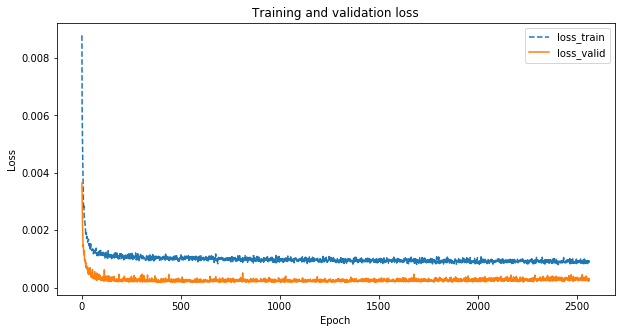

The last epoch: 2561
Finish training at epoch: 561


In [6]:
saved_model = tf.keras.models.load_model('st7_checkpoints/stlstm_1d8.hdf5')

acc = model.history.history['accuracy']
loss = model.history.history['loss']
val_acc = model.history.history['val_accuracy']
val_loss = model.history.history['val_loss']
epochs = range(1, len(loss) + 1)

print('Min of Train Loss: {:.5f}'.format(np.min(loss)))
print('Min of Valid Loss: {:.5f}'.format(np.min(val_loss)))

plt.figure(num = 2, figsize = (10, 5))
plt.plot(epochs, loss, '--', label='loss_train')
plt.plot(epochs, val_loss, label='loss_valid')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('st7_checkpoints/stlstm_1d8_history_loss.png')
plt.show()

print('The last epoch:', es.stopped_epoch+1 )
print('Finish training at epoch:', es.stopped_epoch+1-num_improvement)
